# Single exons, multi-exons, histones and exon length

This notebook will explore the amount of each of the factors on three categories of exon - exons from single exon genes, exons from single exon histone genes (which have no polyA) and normal multiple exon genes. It will also investigate the effect of exon length.

## Update 29/01/17: This file has changed.

Since last, this file has changed. The following changes were made:

* Mitochondrial genes were excluded from the single exon geneset

* The exon set is now composed of exons that never overlap with an intron, rather than exons that are present in all transcripts. The effect of this change is that the number of exons used in the analysis has gone up nearly 10 fold

* These changes have changed some of the headline findings:
    * There is now a distinct depletion of Alyref and eIF4A3 on single exon genes. There is still (just) more than on introns, but not by much. 
    * There remains no difference between histones and multi-exon genes for Alyref, but there is a slight reduction on histones for ChTop. Hoever this difference is not really significant
    * What is signficant is the ratio between Alyref and ChTop for histone genes.
    * The length plots now look much nicer

## Methods

### Exon set

The analysis will use only exons that never overlap with introns. They may not be in every transcript, but they are never intronic. We also only consider exons from genes expressed with normalised counts of greater than 10 from RNAseq experiments. 

### Ratio calculation

Most of the figures used in this notebook are ratios of one or more factors to the FlipIn control. However, the majority of the exon chunks have 0 FlipIn tags in them. Thus to caculate the ratios we first sum the number of FlipIn tags across all exons in the group, then sum the number of say, Alyref tags accross all the exons in the group, and then divide the one by the other. This get around the problem that if we were to divide FlipIn tags by Alyref tags per exons, most of these would be $\frac{0}{0}$. But it does mean that the data will be baised towards highly expressed exons.

### Errorbars and confidence intervals

All error bars shown are 95% bootstrap confidence intervals on the value of the ratio. It is not a measure of how variable the exons are within the group, but of who confident we are about the value of the ratio over the whole group.

P-values are calculated using monte carlo estimation of the permulation p-value. They are all one-tail tests. 

In [15]:
import pandas

def count_ratio(x, test, control):
    '''Sum counts in the test_FLAG_union column of x and divide
    by the sum of the control column of x. If the sum of the control
    column is 0, return Inf'''
    try:
        return float(x["%s_union" % test].sum())/x[control].sum()
    except ZeroDivisionError:
        return pandas.np.inf
    
def bootstrap(x, bootstraps, fun, *args, **kwargs):
    '''Calculate bootstrap bootstraps of the function fun
    from x by sampling with replacement from the rows of
    x and computing `fun` on the results. args and kwargs 
    passed on to fun'''
    def _inner(y):
        xsample = x.sample(n=x.shape[0], replace=True)
        return fun(xsample, *args, **kwargs)
    return pandas.Series(range(bootstraps+1)).apply(_inner)

def boot_ci(x, quantiles=(0.05,0.95), *args,**kwargs):
    '''Calculate the quantiles for bootstraps of x
    args and kwargs are passed on to bootstraps'''
    return bootstrap(x,*args, **kwargs).quantile(quantiles)

def ratio_and_ci(x, groupby, test, control):
    '''Automates calculating ratio between a test and a control for each set in groupby
    and add a 90% confidence interval to it. Groupby can be anything that would
    work with x.groupby(groupby). Uses 1000 bootstraps'''
    x_ci = x.groupby(groupby).apply(boot_ci, bootstraps=1000, fun=count_ratio, test=test, control=control)
    x_ci.columns = ["q0.025", "q0.975"]
    x_ci["ratio"] = x.groupby(groupby).apply(count_ratio, test=test, control=control)
    return x_ci.reset_index()


In [16]:
def resample_diff(x, grouping, samples=1000, alt="different", stat=count_ratio, verbose=True, max_sample=16000, **kwargs):
    '''Test difference in result of stat between group 0 and group 1 after applying groupby(grouping)
    to x. Keeps doulbing the number of samples until the last two values calcualted are within 2.5%
    of the new one or max samples is reached.
    
    Alt is the alternative hypothesis and can be "different", "less" or "greater".
    Keyboard interput returns the last calculated p-value.'''
    old_old_p = 1.0
    old_p = 1.0
    tot_samples = samples
    real_diff = x.groupby(grouping).apply(stat, **kwargs)

    real_diff = real_diff.iloc[1] - real_diff.iloc[0]

    group_sizes = x.groupby(grouping).size()

    def _inner(y):
        shuff = x.sample(n=x.shape[0], replace=False)
        shuff_diff = stat(shuff.iloc[:group_sizes[1]], **kwargs) - stat(shuff.iloc[group_sizes[1]:], **kwargs) 
        return shuff_diff
    
    resample_stats = pandas.Series(range(tot_samples)).apply(_inner)
    
    if alt == "different":
        if real_diff < 0:
            real_diff = -1*real_diff
        p_value = ((resample_stats > real_diff).sum() + (resample_stats < (-1 * real_diff)).sum())/float(samples)
    elif alt == "greater":
        p_value = (resample_stats > real_diff).sum()/float(samples)
    elif alt == "less":
        p_value = (resample_stats < real_diff).sum()/float(samples)
    else:
        raise ValueError("Unknown alternate hypothesis")
      
    try:
        while abs(p_value - old_old_p) > 0.025*p_value or abs(p_value - old_p) > 0.025 * p_value:
        
            if tot_samples >= max_sample:
                raise KeyboardInterrupt

            if verbose:
                print "After %i samples, the p value is %.5f. Convergence not reached" % (tot_samples, p_value)
            
        
            more_resample_stats = pandas.Series(range(tot_samples)).apply(_inner)
            resample_stats = resample_stats.append(more_resample_stats)
            tot_samples += tot_samples
            
            old_old_p = old_p
            old_p = p_value
            
            if alt == "different":
                if real_diff < 0:
                    real_diff = -1*real_diff
                p_value = ((resample_stats > real_diff).sum() + (resample_stats < (-1 * real_diff)).sum())/float(tot_samples)
            elif alt == "greater":
                p_value = (resample_stats > real_diff).sum()/float(tot_samples)
            elif alt == "less":
                p_value = (resample_stats < real_diff).sum()/float(tot_samples)
                
    except KeyboardInterrupt:
        print "breaking after %i samples. Last two errors are: %f, %f" % (tot_samples, old_old_p - p_value, old_p -p_value)
        return p_value
        
 
    return p_value


## Results

In [1]:
import CGAT.Database as D
%load_ext rpy2.ipython
database = "/ifs/projects/proj028/project_pipeline_iCLIP5/csvdb"
annotations = "ATTACH '/ifs/projects/proj028/annotations/csvdb' as anno"

In [11]:
chunk_counts = D.fetch_DataFrame('''SELECT DISTINCT counts.gene_id, counts.exon_id,
                                                    Alyref_FLAG_union,
                                                    Chtop_FLAG_union,
                                                    Nxf1_FLAG_union,
                                                    FlipIn_FLAG_union, 
                                                    PTB_GFP_union,
                                                    RNPS1_GFP_union,
                                                    UPF3B_GFP_union,
                                                    eIF4A3_GFP_union,
                                                    BTZ_GFP_union,
                                                    FlipIn_GFP_union,
                                                    rce.exon, rci.intron,
                                                    ee.exon as expressed_exon,
                                                    ei.intron as expressed_intron
                                    FROM chunk_counts as counts
                                      INNER JOIN reference_chunks_exons as rce 
                                         ON rce.gene_id = counts.gene_id AND rce.exon_id = counts.exon_id
                                      INNER JOIN reference_chunks_introns as rci
                                         ON rci.gene_id = counts.gene_id AND rci.exon_id = counts.exon_id
                                      INNER JOIN reference_chunks_expressed_exons as ee
                                         ON ee.gene_id = counts.gene_id AND ee.exon_id = counts.exon_id
                                      INNER JOIN reference_chunks_expressed_introns as ei
                                         ON ei.gene_id = counts.gene_id AND ei.exon_id = counts.exon_id
                                      INNER JOIN reference_chunks_nGenes as ng
                                         ON ng.gene_id = rce.gene_id AND
                                            ng.exon_id = rce.exon_id
                                    WHERE ng.ngenes == 1 AND expressed_exon>0''',
                                database)

In [8]:
gene_info = D.fetch_DataFrame('''SELECT DISTINCT gi.gene_id, gi.gene_biotype, gi.gene_name, MAX(nval) == 1 as single_exon 
                          FROM anno.gene_info as gi
                           INNER JOIN transcript_info ON transcript_info.gene_id= gi.gene_id
                           INNER JOIN transcript_stats ON transcript_stats.transcript_id = transcript_info.transcript_id
                           WHERE gi.gene_biotype == 'protein_coding'
                           AND transcript_stats.contig != 'chrM'
                           GROUP BY gi.gene_id'''
                       , database, annotations)

In [9]:
histone_genes = D.fetch_DataFrame("SELECT * FROM histone_genes", database)

The following table shows how many exons are being considered in the analysis:

In [12]:
filtered_chunks = chunk_counts.merge(gene_info)\
                              .query("(single_exon==1) | intron==0", engine="python")

filtered_chunks.single_exon = filtered_chunks.single_exon.replace({1: "Single Exon", 0: "Multi-exon"})
filtered_chunks["histone"] = filtered_chunks["gene_id"].apply(lambda x: "histone" if x in histone_genes.Ensembl_Gene_ID.values
                                                  else "")
filtered_chunks = filtered_chunks.query("not ((single_exon=='Multi-exon') and (histone=='histone'))", engine="python")
filtered_chunks.groupby(["single_exon", "histone"]).size().reset_index()

,single_exon,histone,0
0,Multi-exon,,156884
1,Single Exon,,142
2,Single Exon,histone,30


And the follow shows how many genes these come from:

In [13]:
gene_counts = filtered_chunks.groupby(["gene_id", "gene_name", "single_exon", "histone"]).sum().reset_index()
gene_counts.groupby(["single_exon", "histone"]).size().reset_index()

,single_exon,histone,0
0,Multi-exon,,11372
1,Single Exon,,137
2,Single Exon,histone,30


### Enrichment of factors compared to FlipIn

Here we compare the ratio of FlipIn to each factor between multi-exon genes, single-exon histones and non-histone single exon genes. 

In [17]:
factors = pandas.DataFrame({"factor":["Alyref_FLAG","Chtop_FLAG", "Nxf1_FLAG"]})
smh_ratios = factors.groupby("factor").apply(
    lambda x: ratio_and_ci(gene_counts, ["single_exon", "histone"], x.name, "FlipIn_FLAG_union")
    ).reset_index()

In [18]:
smh_ratios.drop("level_1", axis=1)

,factor,single_exon,histone,q0.025,q0.975,ratio
0,Alyref_FLAG,Multi-exon,,47.231196,49.552213,48.336922
1,Alyref_FLAG,Single Exon,,13.831169,24.740000,18.491525
2,Alyref_FLAG,Single Exon,histone,26.421053,140.666667,47.888889
3,Chtop_FLAG,Multi-exon,,46.515860,49.973330,48.186843
4,Chtop_FLAG,Single Exon,,28.333333,52.210526,37.881356
5,Chtop_FLAG,Single Exon,histone,17.111111,89.250000,31.222222
6,Nxf1_FLAG,Multi-exon,,5.339511,5.615908,5.473871
7,Nxf1_FLAG,Single Exon,,4.000000,7.226415,5.288136
8,Nxf1_FLAG,Single Exon,histone,17.923077,106.000000,34.333333


In [19]:
gfp_factors = pandas.DataFrame({"factor":["PTB_GFP", "RNPS1_GFP", "BTZ_GFP", "eIF4A3_GFP"]})
ejc_smh_ratios = gfp_factors.groupby("factor").apply(
    lambda x: ratio_and_ci(gene_counts, ["single_exon", "histone"], x.name, "FlipIn_GFP_union")
    ).reset_index()

In [20]:
ejc_smh_ratios.drop("level_1", axis=1)

,factor,single_exon,histone,q0.025,q0.975,ratio
0,BTZ_GFP,Multi-exon,,208.141249,224.037822,216.207354
1,BTZ_GFP,Single Exon,,15.978769,36.244863,27.882831
2,BTZ_GFP,Single Exon,histone,21.020862,24.866508,23.252772
3,PTB_GFP,Multi-exon,,24.719123,27.180017,25.936989
4,PTB_GFP,Single Exon,,15.632881,35.450980,22.888631
5,PTB_GFP,Single Exon,histone,7.767547,15.526398,10.898004
6,RNPS1_GFP,Multi-exon,,64.115348,69.042219,66.559651
7,RNPS1_GFP,Single Exon,,27.709867,82.434868,58.359629
8,RNPS1_GFP,Single Exon,histone,52.266193,63.846859,57.747228
9,eIF4A3_GFP,Multi-exon,,18.755346,19.949778,19.384892


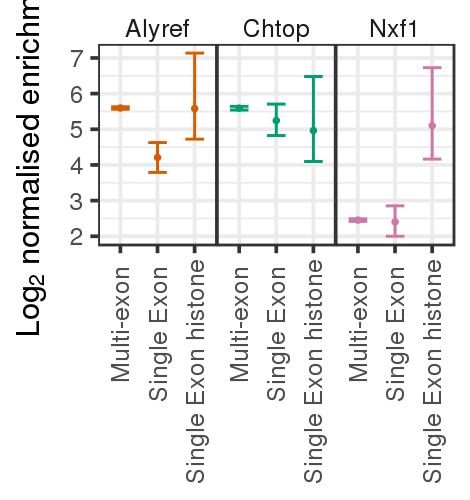

In [68]:
%%R -i smh_ratios -w 470 -h 500 -r 250
cbPalette <- c("#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")
factor_pal = c("Alyref_FLAG"=cbPalette[7],
               "Chtop_FLAG"=cbPalette[4],
               "Nxf1_FLAG"=cbPalette[8],
               "Cntrl_FLAG"=cbPalette[3],
               "eIF4A3_GFP"=cbPalette[2],
               "PTB_GFP"=cbPalette[1],
               "BTZ_GFP"=cbPalette[6],
               "RNPS1_GFP"=cbPalette[5])
library(ggplot2)

ggplot(smh_ratios) +
   aes(x=paste(single_exon, histone), y= log2(ratio), ymin=log2(q0.025), ymax=log2(q0.975),
      col=factor) +
    geom_point(size=0.35) +
    geom_errorbar(width=0.5, lwd=0.4) +
    facet_grid(~factor, labeller=labeller(factor=function(x) gsub("_FLAG","",x))) +
    #coord_flip() +
    theme_bw(base_size=9) +
    theme(strip.text.x=element_text(margin=margin(1,1,2,1)),
          strip.background = element_blank(),
          axis.text.x = element_text(angle=90, hjust=1, vjust=0.5),
          panel.spacing=grid::unit(0, "lines")) +
    scale_color_manual(values=factor_pal, guide=FALSE) +
    xlab(NULL) +
    scale_y_continuous(name=expression(paste(Log[2], " normalised enrichment"))) -> g

ggsave("imgs/single_multi_histone_ratios.pdf", g, width=1.88, height=2, unit="in")
print(g)

[Click here for pdf](imgs/single_multi_histone_ratios.pdf)

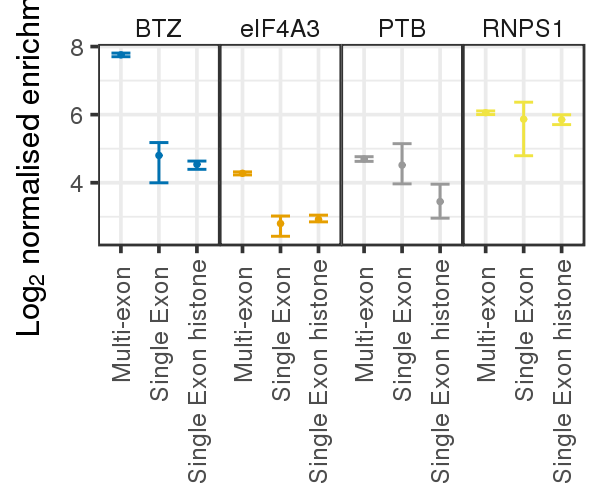

In [69]:
%%R -i ejc_smh_ratios -w 600 -h 500 -r 250
library(ggplot2)

ggplot(ejc_smh_ratios) +
   aes(x=paste(single_exon, histone), y= log2(ratio), ymin=log2(q0.025), ymax=log2(q0.975),
      col=factor) +
    geom_point(size=0.35) +
    geom_errorbar(width=0.5, lwd=0.4) +
    facet_wrap(~factor, labeller=labeller(factor=function(x) gsub("_GFP","",x)),
                ncol=4) +
    theme_bw(base_size=9) +
    theme(strip.text.x=element_text(margin=margin(1,1,2,1)),
          strip.background = element_blank(),
          axis.text.x = element_text(angle=90, hjust=1, vjust=0.5),
          panel.spacing=grid::unit(0, "lines")) +
    scale_color_manual(values=factor_pal, guide=FALSE) +
    xlab(NULL) +
    ylab(expression(paste(Log[2], " normalised enrichment"))) -> g

ggsave("imgs/single_multi_histone_ejc_ratios.pdf", g, width=2.4, height=2, unit="in")
print(g)

[Click here for pdf](imgs/single_multi_histone_ejc_ratios.pdf)

We can see that the there is a difference between single exons and multiple exons for most of the factors. With the exception of Nxf1. For the histones however, Nxf1 does seem to be much higher in the single exon histones than either non-histone single exon genes, or multiple exon genes. The relationship between histones genes and multiexons differs for different factors. It is similar for ALyref, less for ChTop and much less for eIF4A3.  We will calculate p-values from single-exon histone genes against multiple exon genes:

In [15]:
temp = gene_counts.query("histone!='histone'", engine="python")
factors.groupby("factor").apply(lambda x: resample_diff(temp, 
                                      "single_exon",
                                      samples=1000, 
                                      alt="less",
                                      verbose=False, test=x.name, control="FlipIn_FLAG_union"))

factor
Alyref_FLAG    0.0000
Chtop_FLAG     0.0020
Nxf1_FLAG      0.2625
dtype: float64

There is a significant difference for Alyref and for Chtop, but not for Nxf1 (this is exactly as we sould expect from above). Now we look at the histones.

In [16]:
temp = gene_counts.query("single_exon=='Multi-exon' | histone=='histone'", engine="python")
factors.groupby("factor").apply(lambda x: resample_diff(temp, 
                                      "single_exon",
                                      samples=1000, 
                                      alt="greater",
                                      verbose=False, test=x.name, control="FlipIn_FLAG_union"))

factor
Alyref_FLAG    0.65475
Chtop_FLAG     0.95350
Nxf1_FLAG      0.00000
dtype: float64

Note that if we correct for multiple testing, the Chtop result is not significant. This is undoubltedly because of the large number of genes in the standard multi-exon genes that have no clip tags in them (remember we are only using a small portion of the total exonic space. Still, I am farily convinced that the difference is real taking the confidence intervals and the p-values together.

Thus it would seem that there is more Nxf1 on single-exon histones than other genes.

### Alyref to Chtop ratio

Nico suggested that we have more chtop than alyref on single_exon genes. That look plausible by when we looked just at single exon genes (i.e. not breaking out the histone). What does it look like now?

In [17]:
alychtop_ratio = ratio_and_ci(gene_counts, ["single_exon", "histone"], "Alyref_FLAG", "Chtop_FLAG_union")
alychtop_ratio

,single_exon,histone,q0.025,q0.975,ratio
0,Multi-exon,,0.967686,1.016578,0.993701
1,Single Exon,,0.459649,0.547611,0.500822
2,Single Exon,histone,1.286432,1.768293,1.515679


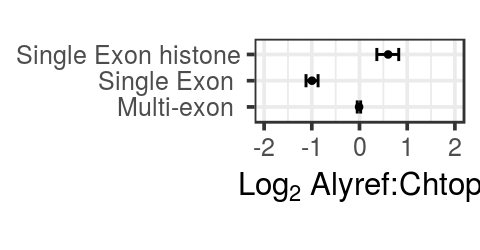

In [18]:
%%R -i alychtop_ratio -w 480 -h 250 -r 250
library(ggplot2)

ggplot(alychtop_ratio) +
   aes(x=paste(single_exon, histone), y= log2(ratio), ymin=log2(q0.025), ymax=log2(q0.975)) +
    geom_point(size=0.5) +
    geom_errorbar(width=0.5, lwd=0.4) +
    coord_flip() +
    theme_bw(base_size=9) +
    xlab(NULL) +
    ylab(expression(paste(Log[2], " Alyref:Chtop") ))+
    theme(aspect.ratio=0.4) +
    ylim(-2,2)-> g

ggsave("imgs/single_multi_histone_alychtop.pdf", g, width=2, height=1, unit="in")
print(g)

[Click here for pdf](imgs/single_multi_histone_alychtop.pdf)

What look like a massive difference on single exon genes (but not histones). Multi-exon genes have around the same amount of Alyref and Chtop, but none-histone single-exon genes have around a thrid as much Alyref as Chtop. Looking at the first plot above, this seems to be a combination of slightly more Chtop and slightly less Alref.

Lets check the p-values:

In [19]:
print "Single Exon vs Multi-exon"

print resample_diff(gene_counts[gene_counts.histone==""], 
              "single_exon", 
              alt="less", 
              verbose=False,
              test="Alyref_FLAG", control="Chtop_FLAG_union")

print "Singe Exon histone vs Multi-exon"

print resample_diff(gene_counts[(gene_counts.histone=="histone") | (gene_counts.single_exon == "Multi-exon")], 
              "single_exon", 
              alt="less", 
              verbose=False,
              test="Alyref_FLAG", control="Chtop_FLAG_union")

Single Exon vs Multi-exon
0.0
Singe Exon histone vs Multi-exon
0.993


The 0 here means $p<\frac{1}{4000}$ or $p<0.00025$. So this is very significant. The difference for the histones is not significant. Thus we can be confident that for non-histone, single-exon genes, there is a lower Alyref:Chtop ratio than for normal multi-exon genes. 

### Exon length

Nico suggested that one explaination might be exon length. It would certainly make sense that if Alyref binding is stabalised by ECJ binding then long exons would have less alyref. Nico also suggested mechanisms of recruiting more Chtop to long exons. Single exon genes are generally longer than a single exon of a multi exon gene (apart from the 3' UTR). Perhaps single exon genes look like 3' UTRs. 

We can look at the factor:FlipIn ratio for different length genes to check this. The analysis below includes only protein coding exons from multi-exon genes (so it is not confounded by the single exon genes):

In [51]:
import CGAT.GTF as GTF
import CGAT.IOTools as IOTools
exon_len, gene_id, exon_id = [], [], []
for exon in GTF.iterator(
    IOTools.openFile(
        "/ifs/projects/proj028/project_pipeline_iCLIP5/transcript_chunks.dir/reference_chunks.gtf.gz")):
    exon_len.append(exon.end - exon.start)
    gene_id.append(unicode(exon.gene_id, "utf-8"))
    exon_id.append(int(exon.exon_id))
    
exon_info = pandas.DataFrame({"exon_length": exon_len, "gene_id": gene_id, "exon_id": exon_id})


In [52]:
exon_len_counts = filtered_chunks.merge(exon_info)
exon_len_counts = exon_len_counts.query("(single_exon=='Multi-exon') & (intron==0 & expressed_exon>=1)", engine="python")
#exon_len_counts = exon_len_counts.query("baseMean > 10", engine="python")

I will break exons into length bins with borders at 10bp, 100bp, 300bp, 1kb, 3kb and > 10kb. The 300bp and 3kb are used as they are half way between adjecent bin edges on a log scale. The table below shows how many exons there are in each category. 

In [53]:
exon_len_counts["len_bin"] = pandas.cut(exon_len_counts.exon_length,[10,100,300,1000,3000,10000])
exon_len_counts["len_bin"].value_counts(sort=False)

(10, 100]        69786
(100, 300]       57794
(300, 1000]       8812
(1000, 3000]      3209
(3000, 10000]     1009
Name: len_bin, dtype: int64

Now we can calculate ratios and confidence intervals for exons in the different length bins

In [54]:
length_ratios = factors.groupby("factor").apply(lambda x:
        ratio_and_ci(exon_len_counts, "len_bin", test=x.name, control="FlipIn_FLAG_union")).\
        reset_index()

In [55]:
ejc_length_ratios = gfp_factors.groupby("factor").apply(lambda x:
        ratio_and_ci(exon_len_counts, "len_bin", test=x.name, control="FlipIn_GFP_union")).\
        reset_index()

In [56]:
length_ratios.drop("level_1", axis=1)

,factor,len_bin,q0.025,q0.975,ratio
0,Alyref_FLAG,"(10, 100]",58.677932,64.327116,61.440083
1,Alyref_FLAG,"(100, 300]",55.995241,60.121492,57.949947
2,Alyref_FLAG,"(300, 1000]",35.263509,39.501647,37.268274
3,Alyref_FLAG,"(1000, 3000]",32.718028,36.685026,34.672757
4,Alyref_FLAG,"(3000, 10000]",27.509828,32.178862,29.818182
5,Chtop_FLAG,"(10, 100]",25.350067,27.881970,26.562672
6,Chtop_FLAG,"(100, 300]",41.119428,44.446462,42.698971
7,Chtop_FLAG,"(300, 1000]",58.298077,65.939394,62.064541
8,Chtop_FLAG,"(1000, 3000]",65.574850,77.151690,70.930233
9,Chtop_FLAG,"(3000, 10000]",48.640182,58.049793,53.083227


In [57]:
ejc_length_ratios.drop("level_1", axis=1)

,factor,len_bin,q0.025,q0.975,ratio
0,BTZ_GFP,"(10, 100]",228.821140,270.387787,250.810418
1,BTZ_GFP,"(100, 300]",261.563271,275.077976,268.002345
2,BTZ_GFP,"(300, 1000]",116.965083,128.286429,122.631329
3,BTZ_GFP,"(1000, 3000]",103.892792,130.075344,116.655015
4,BTZ_GFP,"(3000, 10000]",81.626679,99.027273,89.973148
5,PTB_GFP,"(10, 100]",15.080501,17.344265,16.328792
6,PTB_GFP,"(100, 300]",19.722768,20.917852,20.317228
7,PTB_GFP,"(300, 1000]",28.621240,32.509667,30.467224
8,PTB_GFP,"(1000, 3000]",46.209872,56.895672,51.524679
9,PTB_GFP,"(3000, 10000]",60.136063,72.706271,66.001852


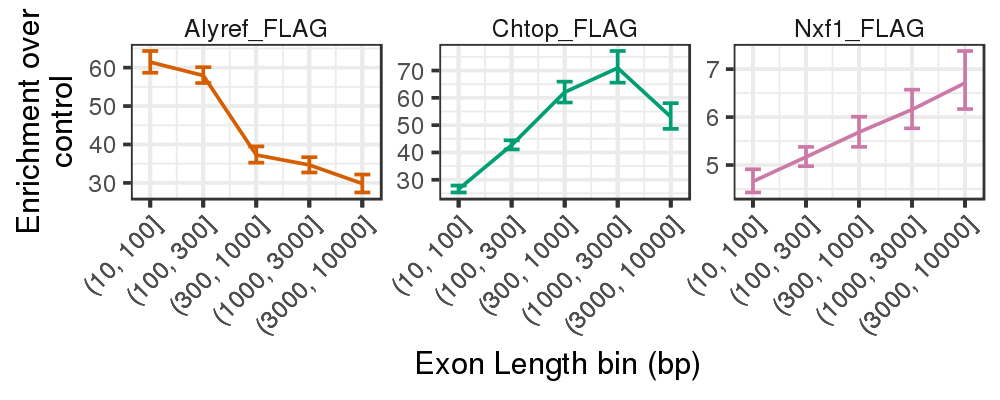

In [58]:
%%R -i length_ratios -w 1000 -h 400 -r 250

ggplot(length_ratios) +
    aes(x=level_1, y=ratio, ymin=q0.025, ymax=q0.975, col=factor) +
    geom_line() +
    geom_errorbar(width=0.3) +
    theme_bw(base_size=9) +
    facet_wrap(~factor, scale="free_y") +
    theme(axis.text.x=element_text(angle=45, hjust=1)) +
    guides(colour=F) +
    scale_color_manual(values=factor_pal) +
    theme(strip.text.x=element_text(margin=margin(1,1,2,1)),
          strip.background = element_blank()) +
    scale_x_continuous(breaks = length_ratios$level_1, 
                       labels=length_ratios$len_bin, 
                       name="Exon Length bin (bp)") +
    ylab("Enrichment over\ncontrol")-> g

ggsave("imgs/length_bin_ratios.pdf", g, width=4, height=1.6, unit="in")
print(g)

[Click here for pdf](imgs/length_bin_ratios.pdf)

So, as Nico predicted, it seems that you get more Chtop on longer exons. The same also appears to be true for Nxf1, although to a lesser extent/starting at a longer length. I wouldn't worry about the longest bin - there are very few exons in here, and I suspect they are not real.

Alow it appears that Alyref is strongest on short exons. No surprise there given the interaction with eIF4A3.

I don't have a way yet to test a p-value on this.

Now we look at the EJC components:

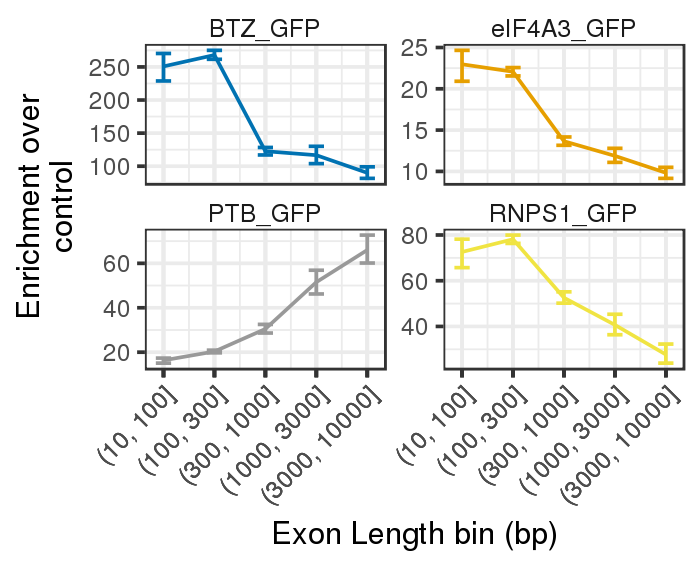

In [59]:
%%R -i ejc_length_ratios  -w 700 -h 570 -r 250

ggplot(ejc_length_ratios) +
    aes(x=level_1, y=ratio, ymin=q0.025, ymax=q0.975, col=factor) +
    geom_line() +
    geom_errorbar(width=0.3) +
    theme_bw(base_size=9) +
    facet_wrap(~factor, scale="free_y") +
    theme(axis.text.x=element_text(angle=45, hjust=1)) +
    guides(colour=F) +
    scale_color_manual(values=factor_pal) +
    theme(strip.text.x=element_text(margin=margin(1,1,2,1)),
          strip.background = element_blank()) +
    scale_x_continuous(breaks = length_ratios$level_1, 
                       labels=length_ratios$len_bin, 
                       name="Exon Length bin (bp)") +
    ylab("Enrichment over\ncontrol")-> g

ggsave("imgs/ejc_length_bin_ratios.pdf", g, height=2.28, width=2.8, units="in")
print(g)

[PDF here](imgs/ejc_length_bin_ratios.pdf)

So not a lot going on here - the errorbars are super large making things hard to see, but in general, eIF4A3 looks like it gets proportionately less compared to FlipIn on long exons - no surprise there. 

PTB looks quite a lot like Nxf1. This is the clearest result here.

RNPS1 looks to be going up down on longer exons, which is interesting because it is up on single exon histones genes.

## Removing the last exon

Its possible that the effect we observed above is purely because long exons are also last exons/UTRs. We will now repeat the analysis after removing any exon where it is the last exon of a transcript.

In [61]:
not_last_exons = D.fetch_DataFrame('''SELECT gene_id, exon_id
                                      FROM reference_chunks_last_pc_exons
                                       WHERE last = 0''', database)

In [62]:
not_last_counts = filtered_chunks.merge(not_last_exons)
internal_exon_len_counts = not_last_counts.merge(exon_info)
internal_exon_len_counts = internal_exon_len_counts.query("(single_exon=='Multi-exon') & (intron==0 & expressed_exon>=1)", engine="python")
#internal_exon_len_counts = internal_exon_len_counts.query("baseMean > 10", engine="python")

In [63]:
internal_exon_len_counts["len_bin"] = pandas.cut(internal_exon_len_counts.exon_length,[10,100,300,1000,3000,10000])
internal_exon_len_counts["len_bin"].value_counts(sort=False)

(10, 100]        45270
(100, 300]       42385
(300, 1000]       2970
(1000, 3000]       401
(3000, 10000]       48
Name: len_bin, dtype: int64

In [64]:
internal_length_ratios = factors.groupby("factor").apply(lambda x:
        ratio_and_ci(internal_exon_len_counts, "len_bin", test=x.name, control="FlipIn_FLAG_union")).\
        reset_index()

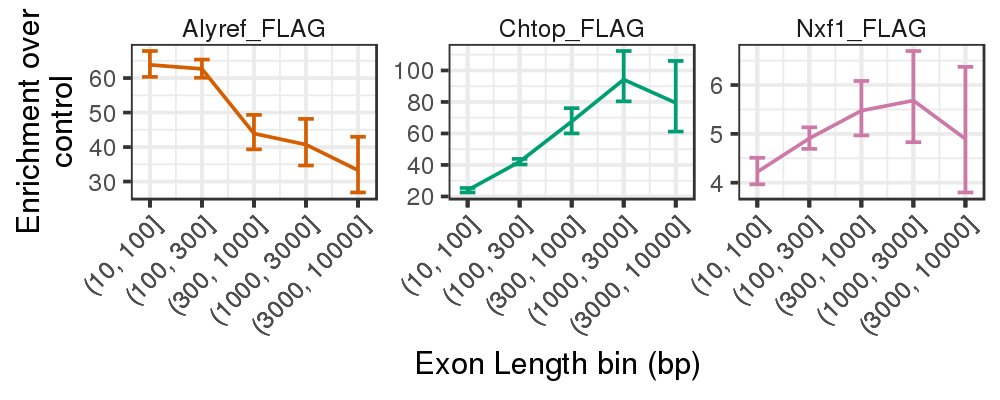

In [65]:
%%R -i internal_length_ratios -w 1000 -h 400 -r 250

ggplot(internal_length_ratios) +
    aes(x=level_1, y=ratio, ymin=q0.025, ymax=q0.975, col=factor) +
    geom_line() +
    geom_errorbar(width=0.3) +
    theme_bw(base_size=9) +
    facet_wrap(~factor, scale="free_y") +
    theme(axis.text.x=element_text(angle=45, hjust=1)) +
    guides(colour=F) +
    scale_color_manual(values=factor_pal) +
    theme(strip.text.x=element_text(margin=margin(1,1,2,1)),
          strip.background = element_blank()) +
    scale_x_continuous(breaks = length_ratios$level_1, 
                       labels=length_ratios$len_bin, 
                       name="Exon Length bin (bp)") +
    ylab("Enrichment over\ncontrol")-> g

ggsave("imgs/internal_exons_length_bin_ratios.pdf", g, width=4, height=1.6, unit="in")
print(g)

[PDF here](imgs/internal_exons_length_bin_ratios.pdf)

Removing the final exons has strengthened the overall pattern in the TREX components. 

In [66]:
internal_ejc_length_ratios = gfp_factors.groupby("factor").apply(lambda x:
        ratio_and_ci(internal_exon_len_counts, "len_bin", test=x.name, control="FlipIn_GFP_union")).\
        reset_index()

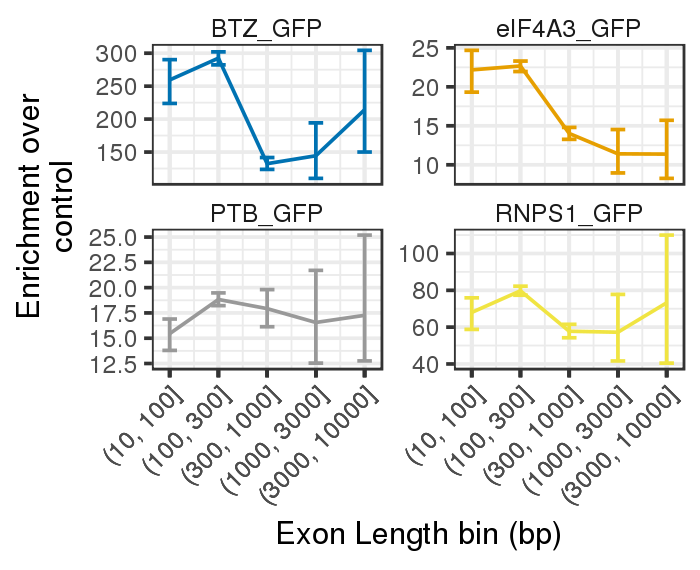

In [67]:
%%R -i internal_ejc_length_ratios  -w 700 -h 570 -r 250

ggplot(internal_ejc_length_ratios) +
    aes(x=level_1, y=ratio, ymin=q0.025, ymax=q0.975, col=factor) +
    geom_line() +
    geom_errorbar(width=0.3) +
    theme_bw(base_size=9) +
    facet_wrap(~factor, scale="free_y") +
    theme(axis.text.x=element_text(angle=45, hjust=1)) +
    guides(colour=F) +
    scale_color_manual(values=factor_pal) +
    theme(strip.text.x=element_text(margin=margin(1,1,2,1)),
          strip.background = element_blank()) +
    scale_x_continuous(breaks = length_ratios$level_1, 
                       labels=length_ratios$len_bin, 
                       name="Exon Length bin (bp)") +
    ylab("Enrichment over\ncontrol")-> g

ggsave("imgs/internal_ejc_length_bin_ratios.pdf", g, height=2.28, width=2.8, units="in")
print(g)

[PDF here](imgs/internal_ejc_length_bin_ratios.pdf)

eIF4A3, RNPS1 and UPF3B all look pretty similar. In particular this is the lower signal in the short exons, but with very large errors. 